In [1]:
%pylab inline
from siph import *

/Users/hantke/Library/Python/2.7/lib/python/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [1]:
%pylab inline
from siph import *


import h5py
import condor

def read_data(experiment, run_number, N=10, skip=1):
    filename = "/Users/hantke/davinci/scratch/fhgfs/xray/%s/preproc/%s_r%04i_ol3.h5" % (experiment,experiment,run_number)
    with h5py.File(filename, "r") as f:
        imgs = asarray(f["entry_1/data_1/data"][-N-skip:-skip])
        msk = asarray(f["entry_1/data_1/mask"])
        gains = asarray(f["entry_1/detector_1/gain"][-N-skip:-skip])
        photon_energies_SLAC = asarray(f["entry_1/FEL/photon_energy_eV_SLAC"][-N-skip:-skip])
        gmds = asarray(f["entry_1/detector_3/pulse_energy_mJ"][-N-skip:-skip])
    return imgs, msk, gains, photon_energies_SLAC, gmds

def apply_mask(imgs, msk):
    tmp = asarray([(msk&condor.utils.pixelmask.PixelMask.PIXEL_IS_IN_MASK)==0])
    tmp = repeat(tmp, imgs.shape[0], axis=0)
    values = imgs.flatten()[tmp.flatten()]
    return values
    

/Users/hantke/Library/Python/2.7/lib/python/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


(0, 10000)

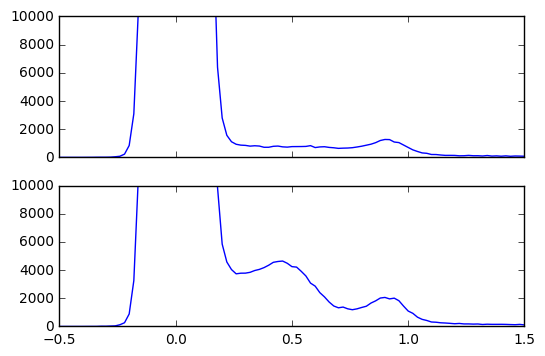

In [13]:
nbins = 101
ex = "amol3416"
N = 10

fig, axs = subplots(2, 1, sharey=True, sharex=True)

# No gas
r = 154
imgs, msk, gains, photon_energies_SLAC, gmds = read_data(ex, r, N, skip=2000)
values = apply_mask(imgs, msk)
photons = values / gains.mean()
I_1, H_1 = histogram(photons, nbins=nbins)
axs[0].plot(I_1, H_1)

# Only N2
r = 152
imgs, msk, gains, photon_energies_SLAC, gmds = read_data(ex, r, N, skip=2000)
values = apply_mask(imgs, msk)
photons = values / gains.mean()
I_N2, H_N2 = histogram(photons, nbins=nbins)
axs[1].plot(I_N2, H_N2)

#from python_tools import gentools 
#[A0, x0, sigma], Hest = gentools.gaussian_fit(I, H)
#print "A0", A0
#print "x0", x0
#print "sigma", sigma
#print I.shape,H.shape

ylim(0, 10000)

0.161381054566 21.1738050373 9969581 -0.0495637949492

(0.0, 20000)

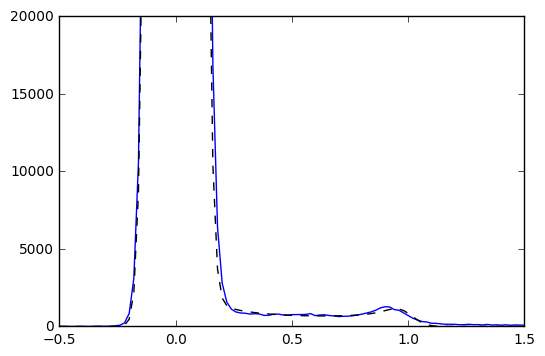

In [46]:
sigma0 = 0.25
L0 = 10
noise_sigma0 = 0.2
sigma_fit, L_fit, nphotons_fit, noise_sigma_fit = fit_hist2(H_1, sigma=sigma0, L=L0, 
                                                           noise_sigma=noise_sigma0)
I_1_fit, H_1_fit = hist_I(sigma_fit, L_fit, nphotons_fit, noise_sigma=noise_sigma_fit, nbins=nbins)

print sigma_fit, L_fit, nphotons_fit, noise_sigma_fit,
plot(I_1, H_1)
plot(I_1_fit, H_1_fit, "--", color="black")
ylim(None, 20000)

In [26]:
hist_I_1 = lambda nphotons: hist_I(sigma_fit, L_fit, nphotons, noise_sigma=noise_sigma_fit, nbins=nbins)
hist_I_N2 = lambda nphotons: hist_I(sigma_fit, L_fit, nphotons, noise_sigma=noise_sigma_fit, nbins=nbins)

H_sum = lambda A0, A, C: abs(A0 * H_1) + abs(A * I1H1(linspace(-0.5*C, 1.5*C, nbins)))
func = lambda x: (H_N2 - H_sum(x[0], x[1], x[2]))[nbins/2:]

In [38]:
x = scipy.optimize.leastsq(func, [1.,1.,0.9])[0]
print x

[ 2.27328526  0.06723588  0.8148089 ]


(0, 10000)

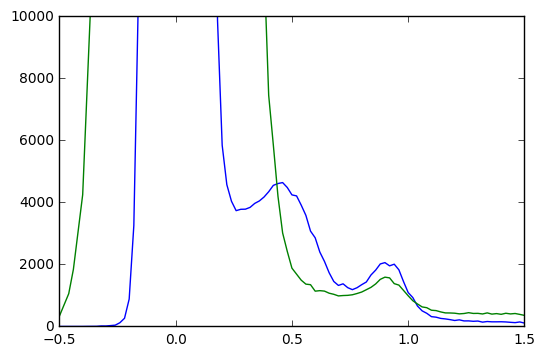

In [45]:
plot(I_N2, H_N2)
#plot(I_N2, H_sum(x[0], x[1], x[2]))
plot(I_N2, H_sum(1., 0.4, 0.4))
ylim(0, 10000)